100%|██████████| 403/403 [00:00<00:00, 1723.24it/s]


{'Clogp_value1': [0.47534833333333326, 0.6584966666666667, 0.7901533333333334, 0.9820616666666667, 0.9841500000000002, 0.8050466666666668, 0.9041583333333335, 0.6910383333333334, 0.7583433333333334, 0.7909050000000002, 0.5257533333333333, 0.8636450000000002, 0.735255, 0.63679, 0.6299283333333336, 0.8405233333333335, 0.7047033333333335, 0.7176100000000001, 0.7352133333333333, 0.6061383333333333, 0.7922066666666667, 0.679975, 0.8373166666666667, 0.6672466666666667, 0.5799333333333334, 0.6315233333333334, 0.9745050000000001, 0.8845966666666667, 0.9559116666666668, 0.9711666666666664, 0.8163466666666668, 0.5731616666666667, 0.5199066666666666, 0.8869933333333333, 0.6000066666666667, 0.72892, 0.7268033333333332, 0.8402299999999999, 0.9735666666666666, 0.5392116666666666, 0.8913066666666667, 0.8335800000000002, 0.9505966666666668, 0.7205066666666667, 0.7341866666666667, 0.41278000000000004, 0.5602816666666667, 0.7125450000000001, 0.6887716666666668, 0.614915, 0.7277766666666667, 0.6529599999

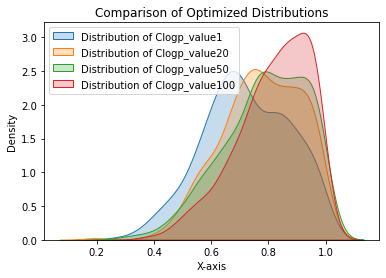

In [1]:
import argparse
import os
import pandas as pd
from rdkit import Chem, RDLogger
from rdkit.Chem import Crippen,AllChem
from tqdm import tqdm
from pdb import set_trace
import data.zinc.prepare_dataset as prep
import multiprocessing as mp
import sys
sys.path.append('../../')
from src.datasets import read_sdf
import subprocess
from multiprocessing import Process
from optparse import OptionParser

import seaborn as sns
from matplotlib import pyplot as plt
import os
import pandas as pd
import logging

# 禁用 RDKit 警告信息
RDLogger.DisableLog('rdApp.*')

def load_rdkit_molecule(xyz_path, obabel_path, true_frag_smi):
    if not os.path.exists(obabel_path):
        subprocess.run(f'obabel {xyz_path} -O {obabel_path}', shell=True)

    supp = Chem.SDMolSupplier(obabel_path, sanitize=False)
    mol = list(supp)[0]

    # Keeping only the biggest connected part
    mol_frags = Chem.GetMolFrags(mol, asMols=True, sanitizeFrags=False)
    mol_filtered = max(mol_frags, default=mol, key=lambda m: m.GetNumAtoms())
    try:
        mol_smi = Chem.MolToSmiles(mol_filtered)
    except RuntimeError:
        mol_smi = Chem.MolToSmiles(mol_filtered, canonical=False)

    # Retrieving linker
    true_frag = Chem.MolFromSmiles(true_frag_smi, sanitize=False)
    match = mol_filtered.GetSubstructMatch(true_frag)# 遍历match的原子和剩下的其他原子，linker的原子，需要的是找linker的原子哪些有键
    if len(match) == 0:
        linker_smi = ''
    else:
        elinker = Chem.EditableMol(mol_filtered)
        for atom in sorted(match, reverse=True):
            elinker.RemoveAtom(atom)
        linker = elinker.GetMol()
        Chem.Kekulize(linker, clearAromaticFlags=True)
        try:
            linker_smi = Chem.MolToSmiles(linker)
        except RuntimeError:
            linker_smi = Chem.MolToSmiles(linker, canonical=False)

    return mol_filtered, mol_smi, linker_smi


def load_molecules(folder, true_frag_smi):
    obabel_dir = f'{folder}/obabel'
    os.makedirs(obabel_dir, exist_ok=True)

    pred_mols = []
    pred_mols_smi = []
    pred_link_smi = []
    for fname in os.listdir(folder):
        number = fname.split('_')[0]
        if number.isdigit():
            pred_path = f'{folder}/{fname}'
            pred_obabel_path = f'{obabel_dir}/{number}_.sdf'
            mol, mol_smi, link_smi = load_rdkit_molecule(pred_path, pred_obabel_path, true_frag_smi)
            pred_mols.append(mol)
            pred_mols_smi.append(mol_smi)
            pred_link_smi.append(link_smi)

    return pred_mols, pred_mols_smi, pred_link_smi


def load_sampled_dataset(folder, idx2true_mol_smi, idx2true_frag_smi):
    pred_mols = []
    pred_mols_smi = []
    pred_link_smi = []
    true_mols_smi = []
    true_frags_smi = []

    for fname in tqdm(os.listdir(folder)):
        if fname.isdigit():
            true_mol_smi = idx2true_mol_smi[int(fname)]
            true_frag_smi = idx2true_frag_smi[int(fname)]

            mols, mols_smi, link_smi = load_molecules(f'{folder}/{fname}', true_frag_smi)
            pred_mols += mols
            pred_mols_smi += mols_smi
            pred_link_smi += link_smi
            true_mols_smi += [true_mol_smi] * len(mols)
            true_frags_smi += [true_frag_smi] * len(mols)
# fragment 原始数据 
    return pred_mols, pred_mols_smi, pred_link_smi, true_mols_smi, true_frags_smi

samples_no = [1,20,50,100]
true_smiles_path = 'datasets/zinc_final_test_smiles.smi'

true_smiles_table = pd.read_csv(true_smiles_path, sep=' ', names=['molecule', 'fragments'])
idx2true_mol_smi = dict(enumerate(true_smiles_table.molecule.values))
idx2true_frag_smi = dict(enumerate(true_smiles_table.fragments.values))

Clogp_dict = {} 
for i in samples_no:
    samples = f'rclogp/samples{i}'
    Clogplist_key = f'Clogp_value{i}'
    pred_mols, pred_mols_smi, pred_link_smi, true_mols_smi, true_frag_smi = load_sampled_dataset(
        folder=samples,
        idx2true_mol_smi=idx2true_mol_smi,
        idx2true_frag_smi=idx2true_frag_smi,
    )
    logplist = []
    for m in pred_mols:
        try:
            Chem.SanitizeMol(m)
            Chem.AssignStereochemistry(m, force=True, cleanIt=True)
            mol = Chem.AddHs(m)
            logp = Crippen.MolLogP(mol)
            logplist.append(logp)
        except:
            continue
    Clogp_list = []
    goal_ClogP = 2.5
    for logp in logplist:
        clogp = max(0.0, 1 - (1/6) * abs(logp - goal_ClogP))
        Clogp_list.append(clogp)
        Clogp_dict[Clogplist_key] = Clogp_list


print(Clogp_dict)

custom_colors = ["red", "green", "blue", "purple"]


# 绘制分布图
for Clogplist_key, Clogp_list in Clogp_dict.items():
    # sns.kdeplot(Clogp_list, color=sns.color_palette("husl")[len(plt.legend().get_lines())], label=f'{Clogplist_key}', shade=True)
    sns.kdeplot(Clogp_list, label=f'Distribution of {Clogplist_key}', shade=True)


# 添加标签和标题
plt.xlabel('X-axis')
plt.ylabel('Density')
plt.title('Comparison of Optimized Distributions')

# 显示图例
plt.legend(bbox_to_anchor=(0, 1), loc='upper left')

# 显示图形
plt.show()


